In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [13]:
data = pd.read_csv("../../Data/cleanedNotRecoded.csv")

df = data.copy()

df = df.drop(["ID", "Customer_ID", "Name", "SSN", "Occupation"], axis=1)

df["Credit_Score"] = df["Credit_Score"].map({"Good":2, "Standard":1, "Poor":0})
df["Credit_Mix"] = df["Credit_Mix"].map({"Good":2, "Standard":1, "Bad":0})

df = pd.get_dummies(df, columns=['Payment_of_Min_Amount', 'Payment_Behaviour'], drop_first=True)

In [14]:
from sklearn.ensemble import IsolationForest

iforestModel = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)

iforestModel.fit(df)

# Predict anomalies (-1 for outliers, 1 for inliers)
df['anomaly'] = iforestModel.predict(df)

df = df[df['anomaly'] == 1].drop(columns=['anomaly'])

In [15]:
X = df.drop(["Credit_Score"], axis=1)
y = df["Credit_Score"]

In [16]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X, y = smote.fit_resample(X, y)

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [18]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, make_scorer
from sklearn.model_selection import cross_val_score, StratifiedKFold


stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True)

In [19]:
import xgboost as xgb

XGBmodel = xgb.XGBClassifier(
        reg_lambda = 2.806695026145806e-08,
        alpha = 1.9793765374390634e-05,
        subsample = 0.8868657639446468,
        colsample_bytree = 0.6370536771529123,
        learning_rate = 0.09788954176891546,
        max_depth = 9,
        n_estimators = 597,
        min_child_weight = 1,
        use_label_encoder=False)
#Best hyperparameters: {'lambda': 2.806695026145806e-08, 'alpha': 1.9793765374390634e-05, 'subsample': 0.8868657639446468, 'colsample_bytree': 0.6370536771529123, 'learning_rate': 0.09788954176891546, 'max_depth': 9, 'n_estimators': 597, 'min_child_weight': 1}


XGBmodel.fit(X_train, y_train)

y_pred = XGBmodel.predict(X_train)

print("=====Train======")
print("Accuracy:", accuracy_score(y_train, y_pred))
print("f1_score:", f1_score(y_train, y_pred, average='weighted'))
print("Classification Report:\n", classification_report(y_train, y_pred))

scores = cross_val_score(XGBmodel, X_train, y_train, cv=stratified_kfold, scoring='accuracy') 

print(f"Cross-validation accuracy scores: {scores}")
print(f"Mean accuracy: {scores.mean()}")

y_pred = XGBmodel.predict(X_test)

print("=====Test======")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("f1_score:", f1_score(y_test, y_pred, average='weighted'))
print("Classification Report:\n", classification_report(y_test, y_pred))

=====Train======
Accuracy: 0.998531810766721
f1_score: 0.9985312775147528
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     34649
           1       1.00      1.00      1.00     34754
           2       1.00      1.00      1.00     34807

    accuracy                           1.00    104210
   macro avg       1.00      1.00      1.00    104210
weighted avg       1.00      1.00      1.00    104210

Cross-validation accuracy scores: [0.89621917 0.89334037 0.89415603 0.88921409 0.89588331]
Mean accuracy: 0.8937625947605795
=====Test======
Accuracy: 0.8996660653283691
f1_score: 0.8986990702849957
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.92      0.90      8772
           1       0.89      0.82      0.85      8667
           2       0.93      0.96      0.95      8614

    accuracy                           0.90     26053
   macro avg       0.90   

In [20]:
booster = XGBmodel.get_booster()

# Get feature importance scores from the booster
feature_importance = booster.get_score(importance_type='weight')

# Convert to DataFrame
importance_df = pd.DataFrame(
    list(feature_importance.items()),
    columns=['Feature', 'Importance']
)

importance_df["Feature"] = list(X.columns)

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

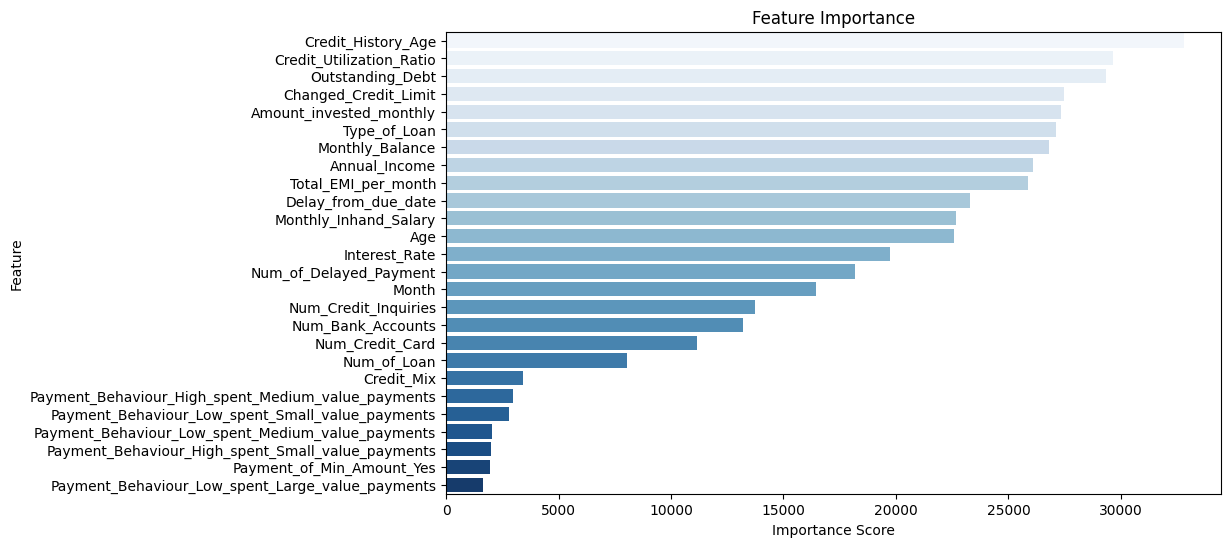

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot size
plt.figure(figsize=(10, 6))

# Create a bar plot
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='Blues')

# Add labels and title
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Feature')

# Show the plot
plt.show()


In [22]:
report = classification_report(y_test, y_pred, output_dict=True)

# Convert the report to a DataFrame for easier plotting
import pandas as pd
report_df = pd.DataFrame(report).transpose()

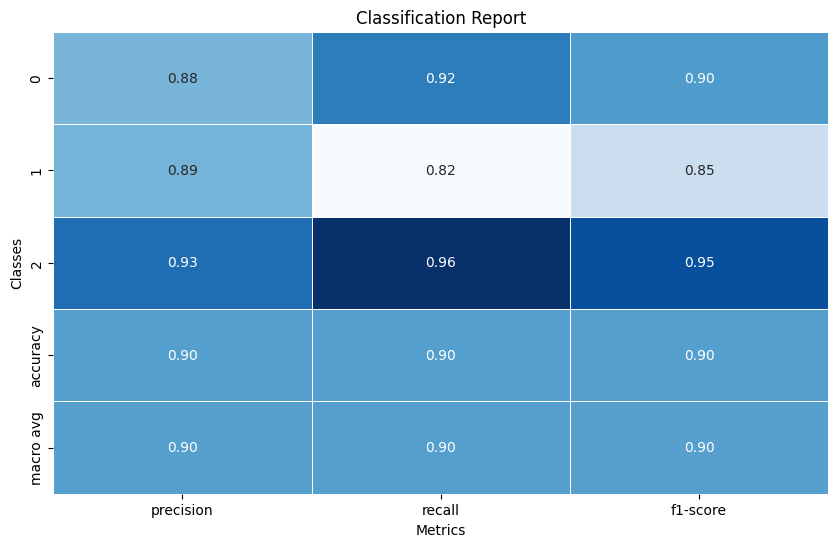

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot size
plt.figure(figsize=(10, 6))

# Create a heatmap using the orange color palette
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap='Blues', fmt=".2f", linewidths=.5, cbar=False)

# Add title and labels
plt.title('Classification Report')
plt.xlabel('Metrics')
plt.ylabel('Classes')

# Show the plot
plt.show()


In [45]:
importance_df

,Feature,Importance
16,Credit_History_Age,32862.0
15,Credit_Utilization_Ratio,30097.0
14,Outstanding_Debt,29475.0
11,Changed_Credit_Limit,27522.0
8,Type_of_Loan,27243.0
18,Amount_invested_monthly,27233.0
19,Monthly_Balance,27101.0
2,Annual_Income,26334.0
17,Total_EMI_per_month,25800.0
9,Delay_from_due_date,23239.0


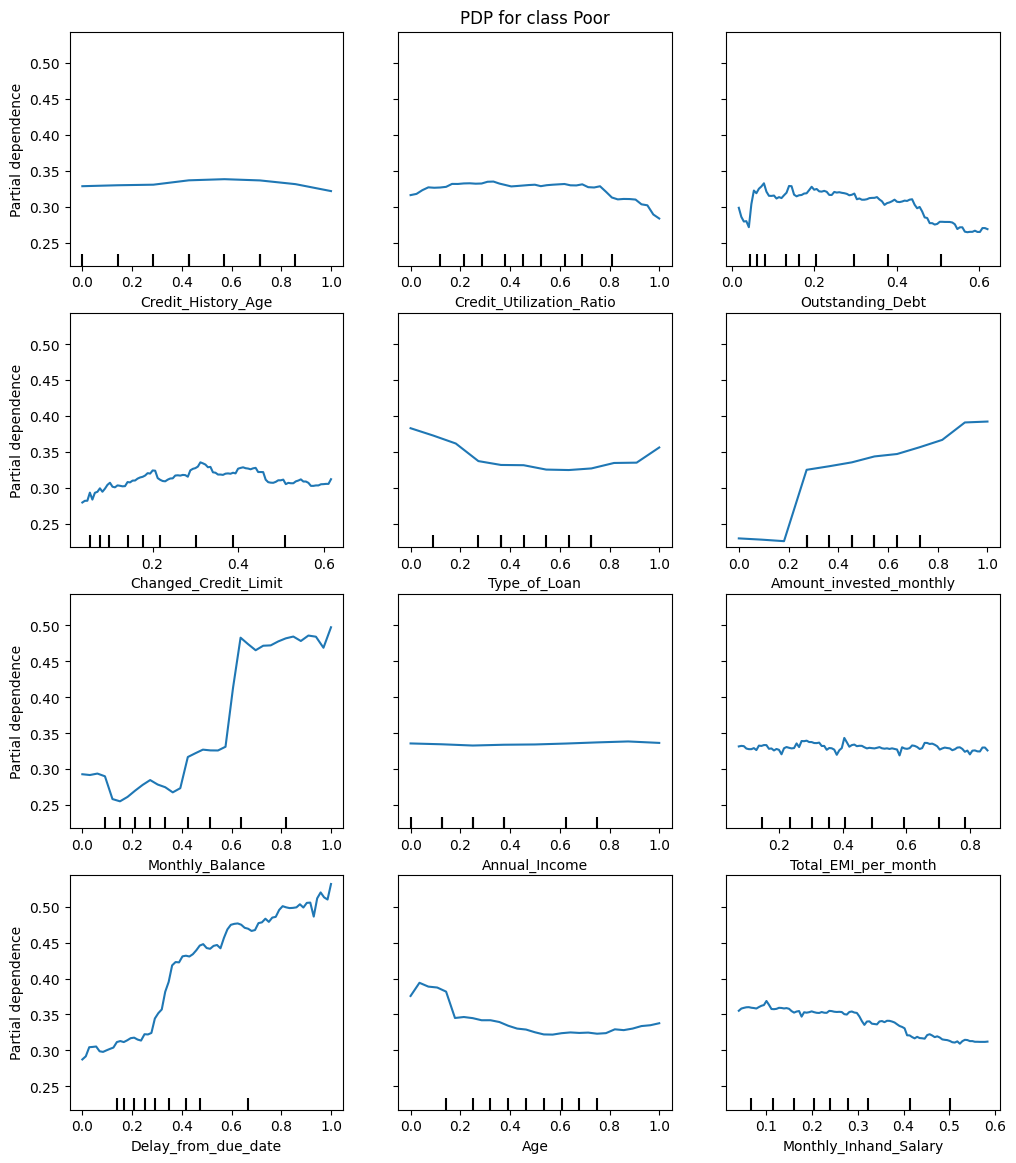

In [62]:
from sklearn.inspection import PartialDependenceDisplay
features = [16,15,14,11,8,18,19,2,17,9,1,3]
f = [0,1,2,3,4,5,6,7,8,9,10,11]
X_train_important = X_train[:, features]
features_name = list(importance_df["Feature"].iloc[:12])
fig, ax = plt.subplots(figsize=(12, 14))
ax.set_title("PDP for class Poor")
PartialDependenceDisplay.from_estimator(XGBmodel, X_train, f, feature_names=features_name,target=0,ax=ax)

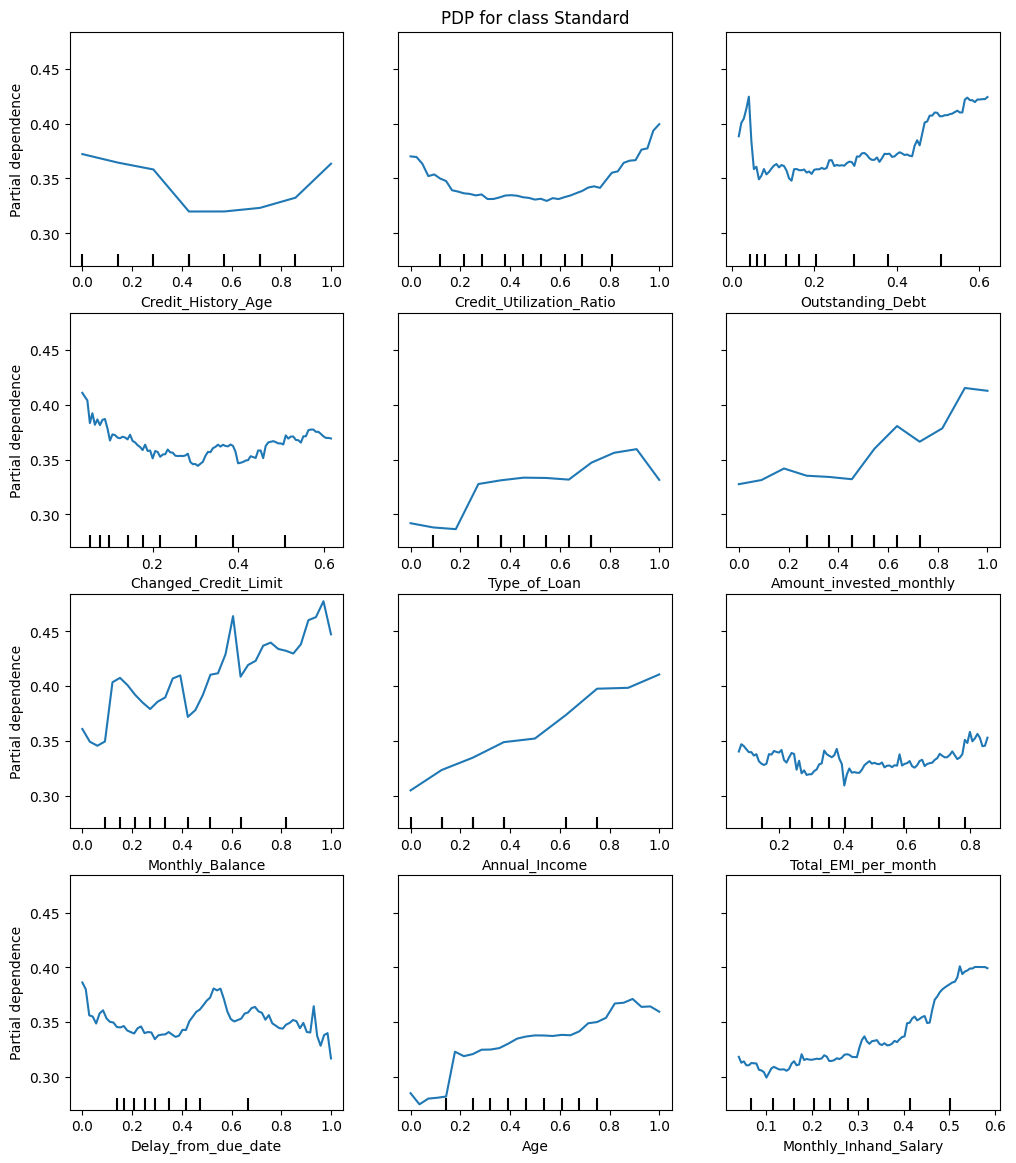

In [63]:
from sklearn.inspection import PartialDependenceDisplay
features = [16,15,14,11,8,18,19,2,17,9,1,3]
f = [0,1,2,3,4,5,6,7,8,9,10,11]
X_train_important = X_train[:, features]
features_name = list(importance_df["Feature"].iloc[:12])
fig, ax = plt.subplots(figsize=(12, 14))
ax.set_title("PDP for class Standard")
PartialDependenceDisplay.from_estimator(XGBmodel, X_train, f, feature_names=features_name,target=1,ax=ax)

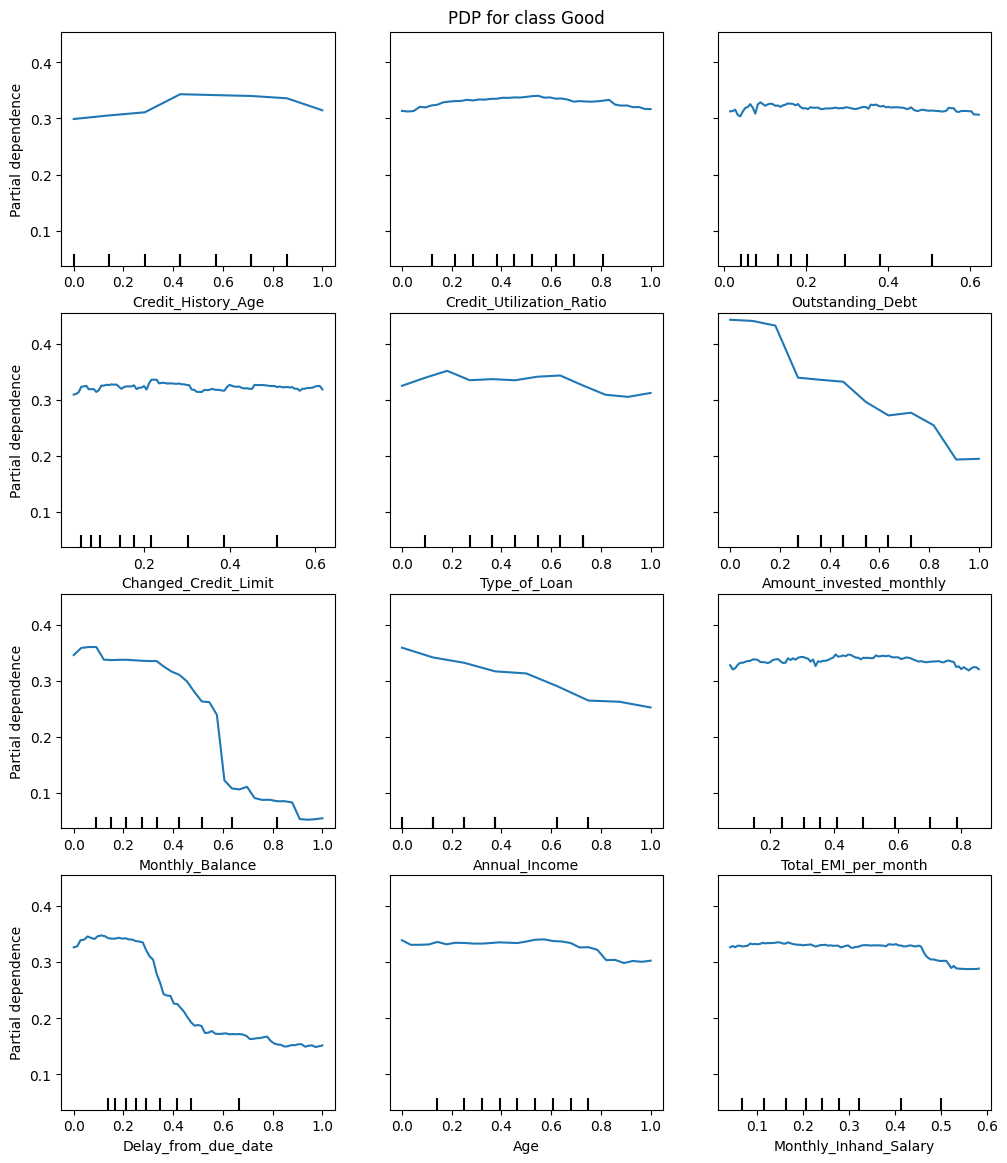

In [64]:
from sklearn.inspection import PartialDependenceDisplay
features = [16,15,14,11,8,18,19,2,17,9,1,3]
f = [0,1,2,3,4,5,6,7,8,9,10,11]
X_train_important = X_train[:, features]
features_name = list(importance_df["Feature"].iloc[:12])
fig, ax = plt.subplots(figsize=(12, 14))
ax.set_title("PDP for class Good")
PartialDependenceDisplay.from_estimator(XGBmodel, X_train, f, feature_names=features_name,target=2,ax=ax)

In [14]:
scaledData = [[ 1.14285714e+00,  9.52380952e-02, -4.04952904e-02, -2.03107447e-02,
   9.09090909e-02,  9.09090909e-02 , 0.00000000e+00  ,0.00000000e+00,
   5.29650910e-01 , 9.72222222e-02 , 7.14285714e-02  ,2.70489586e-02,
   5.88235294e-02,  1.00000000e+00,  1.54096464e-04, -7.07646710e-01,
   2.48138958e-03 ,-1.75408357e-03,  6.55003242e-04,  6.01919528e-04,
   0.00000000e+00 , 0.00000000e+00 , 0.00000000e+00 , 0.00000000e+00,
   0.00000000e+00 , 0.00000000e+00]]

In [17]:
import pickle

with open('xgb_model.pkl', 'rb') as model_file:
            loaded_model = pickle.load(model_file)


In [18]:
predictions = loaded_model.predict(scaledData)
print(predictions)

[1]


In [13]:
X.T

,0,1,2,3,4,5,6,7,8,9,...,130253,130254,130255,130256,130257,130258,130259,130260,130261,130262
Month,1,2,3,4,5,6,7,8,1,2,...,1,3,4,4,6,6,7,5,7,6
Age,23,23,23,23,23,23,23,23,28,28,...,43,26,38,30,26,19,36,37,47,38
Annual_Income,19114.12,19114.12,19114.12,19114.12,19114.12,19114.12,19114.12,19114.12,34847.84,34847.84,...,41673.720836,24858.67,124943.958098,44982.74,75044.98,86804.662689,58145.22,96048.0,18681.465,61646.006545
Monthly_Inhand_Salary,1824.84,1824.84,1824.84,1824.84,1824.84,1824.84,1824.84,1824.84,3037.99,3037.99,...,3673.969076,1977.56,10134.139299,3774.56,5967.75,7279.065358,4577.44,8139.0,1584.79,4953.452255
Num_Bank_Accounts,3,3,3,3,3,3,3,3,2,2,...,2,8,1,4,0,6,4,3,2,3
Num_Credit_Card,4,4,4,4,4,4,4,4,4,4,...,4,6,4,2,1,3,7,4,3,2
Interest_Rate,3,3,3,3,3,3,3,3,6,6,...,6,11,9,11,2,8,9,6,9,7
Num_of_Loan,4,4,4,4,4,4,4,4,1,1,...,3,2,2,2,2,1,2,2,2,2
Type_of_Loan,0.076445,0.076451,0.076448,0.076449,0.076449,0.076449,0.076449,0.076449,-0.084963,-0.084963,...,0.224301,-0.108052,0.033434,-0.314719,-0.116301,-0.336646,-0.234419,-0.194561,-0.125631,-0.206777
Delay_from_due_date,3,-1,3,5,6,8,3,3,3,7,...,9,26,8,7,8,20,1,7,6,11
